# Passion economy creator income data

In this notebook, I explore the distribution of income of Patreon and OnlyFans creators. 

The sources used for this research are [Graphtreon](https://graphtreon.com/) and [ranking-fans.com](https://ranking-fans.com) (NSFW). These sites aggregate data from Patreon and Onlyfans. With only a few API calls, I was able to gather income data for hundreds of thousands of creators.

This research was conducted for the [Good Data Initiative](https://www.gooddatainitiative.com/), a Cambridge-based think tank. It will be used in a review article on the passion economy, that will be published in October 2021. The idea to use raw data from these platforms to reach conclusions about inequalities and the distribution of wealth was largely inspired by Thomas Hollands' article [The Economics of Onlyfans](https://xsrus.com/the-economics-of-onlyfans). While the initial approach was basde on his [source code](https://github.com/ThomHollands/onlyfans) and the data he scraped, the final research does not use his dataset as it is too small (and biased towards popular creators).

In [1]:
import numpy as np
import os
import json
import requests
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct

# Gathering patreon data

In [2]:
if not os.path.exists('patreon_json'):
    os.makedirs('patreon_json')
patreon_categories = ["podcasts", "video", "games", "cosplay", "comics", "writing", "music", "adult-games", "adult-photography", "adult-video", "adult-cosplay", "animation", "drawing-painting", "photography", "crafts-diy", "dance-theater", "magazine", "3d-printing", "other", "adult-animation", "adult-comics", "adult-music", "adult-writing", "adult-drawing-painting", "adult-podcasts", "adult-crafts-diy", "adult-dance-theater", "adult-magazine", "adult-3d-printing", "adult-other"]

for category in patreon_categories:
    if not os.path.isfile('patreon_json/' + category + '.json'):
        print("Getting " + category)
        url = 'https://graphtreon.com/api/creators/' + category
        response = requests.get(url)

        with open('patreon_json/' + category + '.json', 'wb') as outf:
            outf.write(response.content)

In [3]:
patreon_list = []

for category in patreon_categories:
    f = open('patreon_json/' + category + '.json')
    this_json = json.load(f)
    f.close()
    patreon_list += this_json['data']

patreon_list

patreon = pd.DataFrame(patreon_list)
patreon.head()
patreon['earnings'] = patreon['earnings'] .str.replace("/month", "")
patreon['supportPerPatron'] = patreon['supportPerPatron'] .str.replace("/month", "")
patreon['patreonPublishedAt'] = pd.to_datetime(patreon['patreonPublishedAt'])

patreon = patreon[~patreon.earnings.str.contains("/",na=False)] # get rid of all non-monthly figures

patreon['earnings'] = patreon['earnings'].astype(float)
patreon['supportPerPatron'] = patreon['supportPerPatron'].astype(float)
patreon['daysRunning'] = patreon['daysRunning'].astype(int)

patreon = patreon[~patreon.earnings.isna()] # get rid of entries without income data
patreon[['link', 'name','description']] = patreon['link'].str.split('_&_', expand=True)

patreon = patreon.drop(columns='rank')

patreon=patreon.sort_values(by=['earnings'])
patreon.reset_index(drop=True, inplace=True)
cols = patreon.columns.tolist()
cols = [cols[0]] + cols[-2:] + cols[1:-2]
patreon=patreon[cols]

patreon.to_csv('patreon.csv')
patreon
# patreon.describe()

,link,name,description,patrons,earnings,supportPerPatron,patreonPublishedAt,daysRunning
0,animaldrums,Mike F,water color paintings (animaldrums),1,0.09,0.09,2014-10-25 19:33:17,2507
1,DRTDC90,DrTDC90,Chemistry Videos (DRTDC90),1,0.36,0.36,2016-01-13 03:54:23,2062
2,jherussell,Jhe Russell,"Art, Wisdom, Astrology, Syncretism and Love (j...",1,0.37,0.37,2018-10-28 18:48:56,1043
3,FixItFrank,FixItFrank,Youtube Videos (FixItFrank),1,0.39,0.39,2018-08-31 17:47:09,1101
4,jayjackuncensored,Jay Jack Uncensored,Podcasts (jayjackuncensored)_adlt_,1,0.43,0.43,2015-04-10 21:55:34,2340
...,...,...,...,...,...,...,...,...
128551,Flagrant2,Flagrant 2,"Podcast, Video, and more (Flagrant2)",20271,97245.50,4.80,2018-10-01 19:40:24,1070
128552,adeptussteve,Adeptus Steve,Wild Life - An Adult RPG (adeptussteve)_adlt_,10064,103321.00,10.27,2016-04-03 11:27:15,1981
128553,MitchRayTA,Technical Analysis with Mitch Ray,"Trade setups, livestreams, and trading educati...",988,112721.00,114.09,2018-07-13 02:02:53,1150
128554,chapotraphouse,Chapo Trap House,Chapo Trap House Podcast (chapotraphouse),35787,158736.00,4.44,2016-05-23 02:16:26,1931


# Gathering Onlyfans data

In [4]:
if not os.path.exists('onlyfans_json'):
    os.makedirs('onlyfans_json')

for page in range(101+1):
    page=str(page)
    if not os.path.isfile('onlyfans_json/' + page + '.json'):
        print("Getting " + page)
        url = 'https://ranking-fans.com/wp-json/rf/v1/ofprofiles?page=' + page + '&sort=fans&order=0&size=1000&search='
        # headers = {'Accept': 'application/json'}
        # auth = ('username', 'userpass')
        response = requests.get(url)

        with open('onlyfans_json/' + page + '.json', 'wb') as outf:
            outf.write(response.content)



# last page is 101

    

In [5]:
onlyfans_list = []

for page in range(101+1):
    f = open('onlyfans_json/' + str(page) + '.json')
    this_json = json.load(f)
    f.close()
    onlyfans_list += this_json


onlyfans = pd.DataFrame(onlyfans_list)
onlyfans

,username,name,posts,likes,fans,sub_price,pic_url,offer,video,audio,photo,featured
0,suicidegirls,SuicideGirls,4100,2470000,155700,-1,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
1,sarameikasaifree,Sara Mei Kasai,342,1080000,147300,-1,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
2,scarlettmrose,Scarlett Rose ✪,376,277700,146000,-1,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
3,calihotwifevip,MILF WIFE HOTWIFE,37,111100,140900,-1,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
4,maryuofficial,Elf Horny SUPER SQUIRT 🧝‍♀️,755,285500,108800,-1,https://public.onlyfans.com/files/thumbs/c144/...,0,None,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...
101985,bigbootymollygreenn,Molly Green,4,5,-1,20,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
101986,schoutenmax,Max,2,4,-1,-1,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
101987,she.drips,She Drips,4,22,-1,20,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0
101988,brittstyles32,Brittany Styles,8,14,-1,7,https://public.onlyfans.com/files/thumbs/c144/...,0,0,0,0,0


# Pre-processing Onlyfans data

In [6]:
onlyfans = onlyfans.replace('-1', np.nan)
onlyfans = onlyfans.replace(-1, np.nan)
onlyfans = onlyfans.replace('Not found', np.nan)
onlyfans.describe()


# We drop all "free" alt accounts of influencers with paid accounts
onlyfans = onlyfans[~onlyfans.name.str.contains("free",case=False)]
onlyfans = onlyfans[~onlyfans.username.str.contains("free",case=False)]

onlyfans = onlyfans.drop(['name','pic_url','photo','video','audio'],1)
cols = onlyfans.columns

onlyfans[cols[1:]] = onlyfans[cols[1:]].apply(pd.to_numeric, errors='coerce')

In [7]:
onlyfans['likes_per_post'] = onlyfans['likes'] / onlyfans['posts'].astype(float,errors='ignore')
onlyfans['likes_per_post'] = onlyfans['likes_per_post'].replace([np.inf, -np.inf], 0)
onlyfans['likes_per_post'] = onlyfans['likes_per_post'].fillna(0)
onlyfans['engagement_rate'] =  onlyfans['likes_per_post'] / onlyfans['fans']
onlyfans.to_csv('onlyfans.csv')

# Predicting missing Onlyfans data

As only 3k of the ~100k creators in the OnlyFans dataset publish their fan count, and only 2k of those 3k publish their subscription price, we only have income data for ~2k creators. However, predicting the amount of fans from the average likes per post on these accounts should not be too difficult, as the amount of fans = (likes per post) / (engagement rate). The engagement rate can be relatively easily predicted from an account's features, and that can be used to calculate the amount of fans.

The engagement rate tends to hover amount a mean very low mean of only a few %. While we will probably undershoot/overshoot the engagement rate of some creators, on average, the predictions will make sense. This will allow us to describe the revenue of creators more accurately, as we will have many more data points.

The subscription price averages around $10, so setting all missing acounts to use this price should lead to accurate data. However, we can also try to predict the price as well. 

## Predicting the engagement rate from the amount of likes

We can use this to predict the amount of fans later (indirectly)

In [8]:
# mask = ~np.isnan(onlyfans.engagement_rate) & ~np.isnan(onlyfans.likes)


# X=np.array(onlyfans.likes[mask])[:,np.newaxis]
# y=np.array(onlyfans.engagement_rate[mask])


# kernel = 0.01 * RBF(length_scale=[10000]) + WhiteKernel(noise_level=1)

# gp = GaussianProcessRegressor(kernel=kernel).fit(X, y)
# xlim=60000      
# X_ = np.linspace(0,xlim,2000)
# y_mean, y_cov = gp.predict(X_[:,np.newaxis], return_cov=True)                   
# prediction = gp.predict(onlyfans.likes[~np.isnan(onlyfans.likes),np.newaxis])

In [9]:
# plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
# plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')


# plt.scatter(onlyfans.likes[mask], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))

# plt.scatter(onlyfans.likes[~np.isnan(onlyfans.likes)], prediction, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
# plt.xlim(0,xlim)
# plt.ylim(0,10)
# plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
#           % (kernel, gp.kernel_,
#              gp.log_marginal_likelihood(gp.kernel_.theta)))
# plt.tight_layout()

# # TODO deal with nan stuff here

# engagement_rate_pred_1d = np.clip(prediction,0,None)
# indirect_pred_1d = onlyfans.likes_per_post/engagement_rate_pred_1d

## Predicting the amount of fans from the amount of likes

This is a direct prediction of fans, not using engagement rate

In [10]:
# X=np.array(onlyfans.likes[mask])[:,np.newaxis]

# y=np.array(onlyfans.fans[mask])

# kernel = 1000 * RBF(length_scale=[5000]) + WhiteKernel(noise_level=50000)

# gp = GaussianProcessRegressor(kernel=kernel).fit(X, y)
# xlim=60000      
# X_ = np.linspace(0,xlim,2000)
# y_mean, y_cov = gp.predict(X_[:,np.newaxis], return_cov=True)    
# prediction = gp.predict(onlyfans.likes[~np.isnan(onlyfans.likes),np.newaxis] )

In [11]:
# plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
# plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),y_mean + np.sqrt(np.diag(y_cov)),alpha=0.5, color='k')


# plt.scatter(onlyfans.likes[mask], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
# plt.scatter(onlyfans.likes[~np.isnan(onlyfans.likes)], prediction, c='b', s=50, zorder=10, edgecolors=(0, 0, 0))
# plt.xlim(0,xlim)
# plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
#           % (kernel, gp.kernel_,
#              gp.log_marginal_likelihood(gp.kernel_.theta)))
# plt.tight_layout()

# # TODO deal with nan stuff here
# direct_pred_1d = prediction

## Predicting the engagement rate from multiple variables

Instead of just using likes, we can use the likes, like per posts, and amount of posts together.
We can use this to predict the amount of fans later (indirectly).

In [12]:

# mask = ~np.isnan(onlyfans.likes) & ~np.isnan(onlyfans.likes_per_post) & ~np.isnan(onlyfans.posts) & ~np.isnan(onlyfans.engagement_rate)
# mask_2 = ~np.isnan(onlyfans.likes) & ~np.isnan(onlyfans.likes_per_post) & ~np.isnan(onlyfans.posts)
# X = pd.DataFrame([onlyfans.likes[mask],onlyfans.likes_per_post[mask],onlyfans.posts[mask]]).T

# y=np.array(onlyfans.engagement_rate[mask])

# kernel = 0.01 * RBF(length_scale=[10000,10,150],length_scale_bounds=(1e-6,1.47e+12)) + WhiteKernel(noise_level=5)

# gp = GaussianProcessRegressor(kernel=kernel).fit(X, y)
# xlim=600000      
# X_ = pd.DataFrame([onlyfans.likes[mask_2],onlyfans.likes_per_post[mask_2],onlyfans.posts[mask_2]]).T                        
# Y_ = gp.predict(X_)



In [13]:

# plt.scatter(onlyfans.likes[mask], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
# plt.xlim(0,50000)
# plt.ylim(0,1)
# plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
#           % (kernel, gp.kernel_,
#              gp.log_marginal_likelihood(gp.kernel_.theta)))
# plt.tight_layout()

# engagement_rate_pred_jittery = np.clip(Y_,0,None)
# plt.scatter(onlyfans.likes[mask_2], engagement_rate_pred_jittery, c='b', s=10, zorder=10, edgecolors=(0, 0, 0))

# # TODO nan stuff here
# indirect_pred_jittery = onlyfans.likes_per_post/engagement_rate_pred_jittery

## Predicting the amount of fans from multiple variables

Instead of just using likes, we can use the likes, like per posts, and amount of posts together.
This is a direct prediction of fans, not using engagement rate

In [14]:

# mask = ~np.isnan(onlyfans.likes) & ~np.isnan(onlyfans.likes_per_post) & ~np.isnan(onlyfans.posts) & ~np.isnan(onlyfans.fans)
# mask_2 = ~np.isnan(onlyfans.likes) & ~np.isnan(onlyfans.likes_per_post) & ~np.isnan(onlyfans.posts)
# X = pd.DataFrame([onlyfans.likes[mask],onlyfans.likes_per_post[mask],onlyfans.posts[mask]]).T

# y=np.array(onlyfans.fans[mask])

# kernel = 0.01 * RBF(length_scale=[10000,10,150],length_scale_bounds=(1e-6,1.47e+12)) + WhiteKernel(noise_level=5)

# gp = GaussianProcessRegressor(kernel=kernel).fit(X, y)
# xlim=600000      
# X_ = pd.DataFrame([onlyfans.likes[mask_2],onlyfans.likes_per_post[mask_2],onlyfans.posts[mask_2]]).T                        
# Y_ = gp.predict(X_)

In [15]:
# plt.scatter(onlyfans.likes[mask], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
# plt.xlim(0,50000)
# plt.ylim(0,1)
# plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
#           % (kernel, gp.kernel_,
#              gp.log_marginal_likelihood(gp.kernel_.theta)))
# plt.tight_layout()

# direct_pred = np.clip(Y_,0,None)
# plt.scatter(onlyfans.likes[mask_2], Y_, c='b', s=10, zorder=10, edgecolors=(0, 0, 0))

# # TODO nan stuff


# Calculating which fans prediction is best

In [16]:
# indirect_pred_1d =  np.clip(indirect_pred_1d,0,None)
# direct_pred_1d =  np.clip(direct_pred_1d,0,None)
# indirect_pred_jittery =  np.clip(indirect_pred_jittery,0,None)
# # indirect_pred_stable =  np.clip(indirect_pred_stable,0,None)
# direct_pred =  np.clip(direct_pred,0,None)



# a=((indirect_pred_1d[mask] - onlyfans.num_fans[mask])**2).mean() # bad mse at 40502k
# b=((direct_pred_1d[mask] - onlyfans.num_fans[mask])**2).mean() # ok mse at 800k, but median is too low at 0.018, mean too low at 0.029, max too low at 0.17
# c=((indirect_pred_jittery[mask]  - onlyfans.num_fans[mask])**2).mean() # good mse at 219k. median good at 0.029, mean good at 0.0624. max good at 0.67
# # d=((indirect_pred_stable[mask]  - onlyfans.num_fans[mask])**2).mean() # bad mse at 29052k
# e=((direct_pred[mask]  - onlyfans.num_fans[mask])**2).mean() # good mse at 141k, 50% too law at 0.017, mean too la at 0.023

# mses = np.array([a,b,c,e])
# mses

# Predicting the amount of fans for all creators

In [17]:
# TODO UNCOMMENT to predict fans for all 100k creators. Leave commented to just use the 3k creators that publish fans.

# new_mask = np.isnan(onlyfans.engagement_rate)

# onlyfans.loc[new_mask,'engagement_rate'] = engagement_rate_pred_jittery[new_mask]
# new_mask2 = np.isnan(onlyfans.fans)
# onlyfans.loc[new_mask,'fans'] = indirect_pred_jittery[new_mask2]

# onlyfans.fans = onlyfans.num_fans.round()
# onlyfans.fans = onlyfans.num_fans.replace([np.inf, -np.inf], np.nan)


# Predicting the price for each creator

This might not work, as the sub price is not decided by the amount of likes and the likes per post and such (which the amount of fans was). Instead, it is decided by the creator before fans ever engage.

If this doesn't work, we can just use an avg price of $10.

However, because 2k of the 3k creators that publish fan data also publish their subscription price, and 80k out of the total 100k creators publish their subscription price, we do not need to do so. The data that we have is already enough.

In [18]:
# # multiple dimensions
# mask = ~np.isnan(onlyfans.sub_price)
# X = pd.DataFrame([onlyfans.likes[mask],onlyfans.likes_per_post[mask],onlyfans.num_posts[mask],onlyfans.num_fans[mask]]).T


# y=np.array(onlyfans.sub_price[mask])
# kernel = 10 * RBF(length_scale=[10000,10,30,100],length_scale_bounds=(10,10000)) + WhiteKernel(noise_level=0.1,noise_level_bounds=(1e-6,30))

# gp = GaussianProcessRegressor(kernel=kernel).fit(X, y)
# xlim=600000      
# X_ = pd.DataFrame([onlyfans.likes,onlyfans.likes_per_post,onlyfans.num_posts,onlyfans.num_fans]).T                        


# plt.scatter(onlyfans.likes[mask], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
# Y_ = np.clip(gp.predict(X_),4.99,None)
# plt.scatter(onlyfans.likes, Y_, c='b', s=10, zorder=10, edgecolors=(0, 0, 0))
# plt.xlim(0,xlim)
# plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
#           % (kernel, gp.kernel_,
#              gp.log_marginal_likelihood(gp.kernel_.theta)))
# plt.tight_layout()

# # gp.predict([[100]])
# price_pred = Y_



In [19]:
# Just set empty prices to $10, the median (but below the mean)

# onlyfans['sub_price'] = onlyfans['sub_price'].fillna(10,axis=0)



# Calculating Onlyfans revenue

In [20]:
# monthly revenue
onlyfans['revenue'] = onlyfans['sub_price'] * onlyfans['fans']


# Plots

In [21]:
patreon.describe().round(2)

,patrons,earnings,supportPerPatron,daysRunning
count,128556.00,128556.00,128556.00,128556.00
mean,32.53,178.44,6.93,817.24
std,262.60,1314.61,10.34,632.25
min,1.00,0.09,0.06,0.00
25%,2.00,8.42,2.85,316.00
50%,5.00,26.79,4.60,653.00
75%,15.00,96.68,8.12,1176.00
max,35787.00,172831.00,920.70,3043.00


In [22]:
onlyfans.describe().round(2)

,posts,likes,fans,sub_price,offer,featured,likes_per_post,engagement_rate,revenue
count,100254.00,69674.00,2744.00,80345.00,100254.00,100254.00,100254.00,2744.00,1907.00
mean,68.28,4536.68,925.50,12.11,1.24,0.00,9.75,0.64,491.77
std,315.14,56823.63,7673.47,8.16,8.15,0.01,96.42,1.63,5124.75
min,1.00,1.00,2.00,3.00,0.00,0.00,0.00,0.00,9.00
25%,4.00,13.00,5.00,7.00,0.00,0.00,0.00,0.09,40.00
50%,11.00,75.00,12.00,10.00,0.00,0.00,1.50,0.30,99.00
75%,38.00,436.00,42.00,15.00,0.00,0.00,5.53,0.67,255.00
max,18300.00,4000000.00,155700.00,100.00,90.00,1.00,12373.54,47.60,214400.00


In [23]:
patreon2 = patreon.copy(deep=True)
patreon2 = patreon2.drop(['link','description','daysRunning','patreonPublishedAt'],axis=1)
patreon2.columns = ['name','fans','income','income_per_fan']
patreon2['platform'] = 'Patreon'
# patreon2

onlyfans2=onlyfans.copy(deep=True)
onlyfans2 = onlyfans2.drop(['posts','likes','offer','featured','engagement_rate','likes_per_post'],axis=1)
onlyfans2 = onlyfans2[onlyfans2.columns[[0,1,3,2]]]
onlyfans2.columns = ['name','fans','income','income_per_fan']
onlyfans2['platform'] = 'Onlyfans'


# patreon2

#combined_df  = 

In [39]:
combined = pd.concat([patreon2,onlyfans2],axis=0,ignore_index=True)
combined

,name,fans,income,income_per_fan,platform
0,Mike F,1.0,0.09,0.09,Patreon
1,DrTDC90,1.0,0.36,0.36,Patreon
2,Jhe Russell,1.0,0.37,0.37,Patreon
3,FixItFrank,1.0,0.39,0.39,Patreon
4,Jay Jack Uncensored,1.0,0.43,0.43,Patreon
...,...,...,...,...,...
228805,bigbootymollygreenn,NaN,NaN,20.00,Onlyfans
228806,schoutenmax,NaN,NaN,NaN,Onlyfans
228807,she.drips,NaN,NaN,20.00,Onlyfans
228808,brittstyles32,NaN,NaN,7.00,Onlyfans


Text(0, 0.5, '% of Creators')

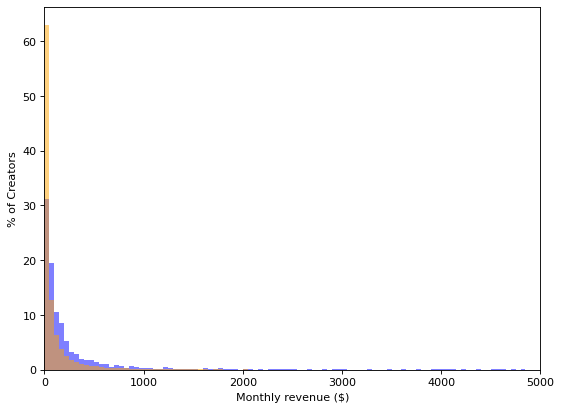

In [25]:
# a_length = onlyfans.revenue.dropna().size
# a = 100*(a/a_length)
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

width=50
xlim = 5000
hist1, bins1 = np.histogram(onlyfans.revenue.dropna(),bins=range(0,xlim,width))
plt.bar(bins1[:-1],100*hist1.astype(np.float32) / hist1.sum(), width=(width),color='blue',alpha=0.5,align='edge')

hist2, bins2 = np.histogram(patreon.earnings.dropna(),bins=range(0,xlim,width))
plt.bar(bins2[:-1],100*hist2.astype(np.float32) / hist2.sum(), width=(width),color='orange',alpha=0.5,align='edge')

# a.plot(kind='hist',bins=500,xlim=(0,10000),density=True)
# patreon.earnings.dropna().plot(kind='hist',bins=500,xlim=(0,10000))
plt.xlabel('Monthly revenue ($)')
plt.xlim(0,xlim)
plt.ylabel('% of Creators')

# plt.ylim(0,200)

Text(0, 0.5, '% of Creators')

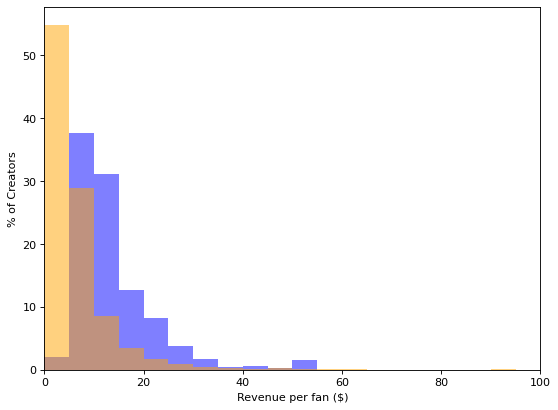

In [26]:
figure(figsize=(8, 6), dpi=80)

width=5
xlim = 100
hist1, bins1 = np.histogram(onlyfans.sub_price.dropna(),bins=range(0,xlim,width))
plt.bar(bins1[:-1],100*hist1.astype(np.float32) / hist1.sum(), width=(width),color='blue',alpha=0.5,align='edge')

hist2, bins2 = np.histogram(patreon.supportPerPatron.dropna(),bins=range(0,xlim,width))
plt.bar(bins2[:-1],100*hist2.astype(np.float32) / hist2.sum(), width=(width),color='orange',alpha=0.5,align='edge')

# a.plot(kind='hist',bins=500,xlim=(0,10000),density=True)
# patreon.earnings.dropna().plot(kind='hist',bins=500,xlim=(0,10000))
plt.xlabel('Revenue per fan ($)')
plt.xlim(0,xlim)
plt.ylabel('% of Creators')

# plt.ylim(0,200)

Text(0, 0.5, '% of Creators')

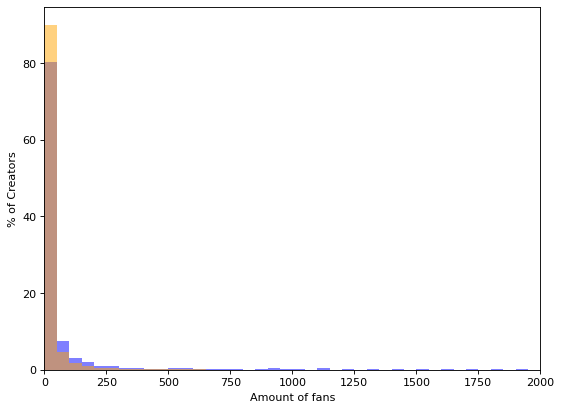

In [27]:
figure(figsize=(8, 6), dpi=80)

width=50
xlim = 2000
hist1, bins1 = np.histogram(onlyfans.fans.dropna(),bins=range(0,xlim,width))
plt.bar(bins1[:-1],100*hist1.astype(np.float32) / hist1.sum(), width=(width),color='blue',alpha=0.5,align='edge')

hist2, bins2 = np.histogram(patreon.patrons.dropna(),bins=range(0,xlim,width))
plt.bar(bins2[:-1],100*hist2.astype(np.float32) / hist2.sum(), width=(width),color='orange',alpha=0.5,align='edge')

# a.plot(kind='hist',bins=500,xlim=(0,10000),density=True)
# patreon.earnings.dropna().plot(kind='hist',bins=500,xlim=(0,10000))
plt.xlabel('Amount of fans')
plt.xlim(0,xlim)
plt.ylabel('% of Creators')

# plt.ylim(0,200)

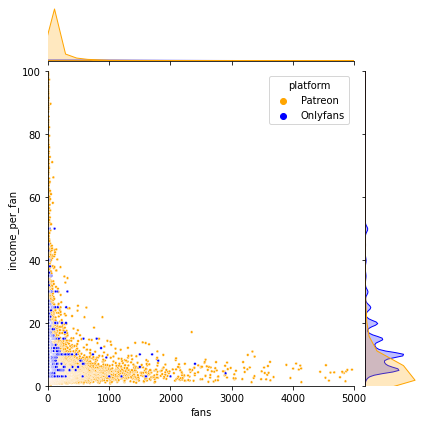

In [38]:
# TODO make histograms on the side, normalize them

sns.jointplot(data=combined,x='fans',y='income_per_fan',xlim=(0,5000),ylim=(0,100),hue='platform',palette=['orange','blue'],marker=".",joint_kws={"s": 30,'alpha':1})

# joint_kws={"s": 20,'alpha':0.5}

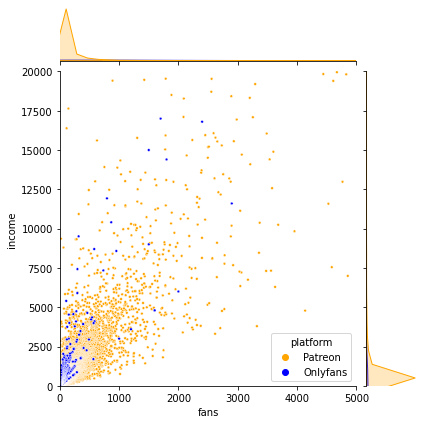

In [44]:
# TODO why is the margin plot only showing Patreon data?

sns.jointplot(data=combined,x='fans',y='income',xlim=(0,5000),ylim=(0,20000),hue='platform',palette=['orange','blue'],marker=".",joint_kws={"s": 30,'alpha':1})

# joint_kws={"s": 20,'alpha':0.5}

# Calculating indices and percentages of income

This bit is still from Thomas Hollands' original source code. I have not touched it yet.

In [ ]:
# # TODO do this for patreon

# # what percentaige of revenue is top account?
# total_rev = onlyfans['revenue'].sum()
# num_acc = onlyfans['revenue'].count()
# max_rev = onlyfans['revenue'].max()
# top_10p = onlyfans['revenue'].nlargest(int(np.floor(onlyfans['revenue'].count()*0.10))).sum()
# top_1p = onlyfans['revenue'].nlargest(int(np.floor(onlyfans['revenue'].count()*0.01))).sum()
# top_20p = onlyfans['revenue'].nlargest(int(np.floor(onlyfans['revenue'].count()*0.2))).sum()
# print(max_rev/total_rev)
# print('top 10%:', top_10p/total_rev)
# print('top 1%:', top_1p/total_rev)
# print('top 20%:',top_20p/total_rev)
# # top 10% make 73% of the total revenue
# # top 1% makes 45% of total revenue

In [ ]:
# onlyfans['revenue'].nsmallest(int(np.floor(onlyfans['revenue'].count()*0.5))).plot(kind='hist',bins=30)
# #plt.style.use('viridis')
# plt.xlabel('Monthly Revenue, $ (bottom 50% of accts)')
# print(onlyfans['revenue'].describe())

In [ ]:
# def gini(array):
#     """Calculate the Gini coefficient of a numpy array."""
#     # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
#     # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
#     array = array.flatten() #all values are treated equally, arrays must be 1d
#     if np.amin(array) < 0:
#         array -= np.amin(array) #values cannot be negative
#     array += 0.0000001 #values cannot be 0
#     array = np.sort(array) #values must be sorted
#     index = np.arange(1,array.shape[0]+1) #index per array element
#     n = array.shape[0]#number of array elements
#     return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

# print(gini(np.array(onlyfans['revenue'].dropna())))
# # gini coefficient of 0.89

In [ ]:
# # get total revenue of onlyfans
# n_creators = 30000 # half of stated in https://thewest.com.au/news/wa/wa-model-jem-wolfie-breaks-social-media-makes-millions-on-onlyfans-ng-b881158181z?fbclid=IwAR3ALMztvknNbHKdY7_pHWc9SwNTOfUjTbKKxdncIJZCa4o3JqMINZptHao
# rev_per_creator = onlyfans['revenue'].mean() * 0.2
# total_rev_month = n_creators * rev_per_creator
# total_rev = total_rev_month * 12
# print('Top-down estimate of yearly revenue is:',total_rev / 1000000)
# print(rev_per_creator)
# # bottom up calc
# n_paying_users = 5e6 # half of 10m users, extrapolated from https://thewest.com.au/news/wa/wa-model-jem-wolfie-breaks-social-media-makes-millions-on-onlyfans-ng-b881158181z?fbclid=IwAR3ALMztvknNbHKdY7_pHWc9SwNTOfUjTbKKxdncIJZCa4o3JqMINZptHao
# mean_sub_price = onlyfans['sub_price'].mean() # about $8.5 a month
# print(mean_sub_price)
# monthly_rev = mean_sub_price*n_paying_users * 0.2
# yearly_rev = 12 * monthly_rev
# print('Bottom up estimate of Yearly Revenue is: ',yearly_rev / 1e6)